In [1]:
%%html
<iframe style="aspect-ratio: 1200 / 630; width:100%; height:fit-content;" src="https://www.coindesk.com/embedded-chart/GRdgwdpLtpFTd" width="100%" frameborder="0" scrolling="no"></iframe>

# Import libraries

In [2]:
import tensorflow as tf
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Get Data

In [3]:
def get_binance_klines(symbol, interval, start_str, end_str=None):
    url = "https://api.binance.com/api/v3/klines"
    start_time = int(pd.Timestamp(start_str).timestamp() * 1000)
    end_time = int(pd.Timestamp(end_str).timestamp() * 1000) if end_str else None
    all_data = []
    
    while start_time < end_time:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': 1000
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if response.status_code != 200 or not data:
            print(f"Error: {response.status_code}, {response.text}")
            break
        
        all_data.extend(data)
        start_time = data[-1][0] + 1  # Move to the next time window
    
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
        'taker_buy_quote_asset_volume', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.rename(columns={'timestamp': 'Date'}, inplace=True)
    df.set_index('Date', inplace=True)
    return df


symbol = 'BTCUSDT'
interval = '1d'
start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

df = get_binance_klines(symbol, interval, start_date, end_date)

if df is not None:
    # Save the data to a CSV file
    df.to_csv('binance_btcusdt_price_history.csv', index=False)
    print("Historical Bitcoin price data from Binance downloaded and saved to 'binance_btcusdt_price_history.csv'")

    # Get the last element of the DataFrame
    last_element = df.iloc[-1]
    print("\nLast element of the DataFrame:")
    print(last_element)

Historical Bitcoin price data from Binance downloaded and saved to 'binance_btcusdt_price_history.csv'

Last element of the DataFrame:
open                                 60293.30000000
high                                 62420.00000000
low                                  60257.06000000
close                                61688.87000000
volume                               30698.20037000
close_time                            1719359999999
quote_asset_volume              1884578890.32693710
number_of_trades                            1261971
taker_buy_base_asset_volume          15064.06370000
taker_buy_quote_asset_volume     924789760.34371060
ignore                                            0
Name: 2024-06-25 00:00:00, dtype: object


The bitcoin historical data in [Binance](https://www.binance.com/en) starts in **2017-08-17**

In [4]:
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
Date,,,,,,,,,,,
2017-08-17,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
2017-08-18,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
2017-08-19,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
2017-08-20,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
2017-08-21,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2505 entries, 2017-08-17 to 2024-06-25
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open                          2505 non-null   object
 1   high                          2505 non-null   object
 2   low                           2505 non-null   object
 3   close                         2505 non-null   object
 4   volume                        2505 non-null   object
 5   close_time                    2505 non-null   int64 
 6   quote_asset_volume            2505 non-null   object
 7   number_of_trades              2505 non-null   int64 
 8   taker_buy_base_asset_volume   2505 non-null   object
 9   taker_buy_quote_asset_volume  2505 non-null   object
 10  ignore                        2505 non-null   object
dtypes: int64(2), object(9)
memory usage: 234.8+ KB


In [6]:
len(df)

2505

In [7]:
btc_prices = pd.DataFrame(df['close']).rename(columns={'close': 'Price'})
btc_prices['Price'] = btc_prices['Price'].astype(float)
btc_prices.head()

,Price
Date,
2017-08-17,4285.08
2017-08-18,4108.37
2017-08-19,4139.98
2017-08-20,4086.29
2017-08-21,4016.00


### Visualize !

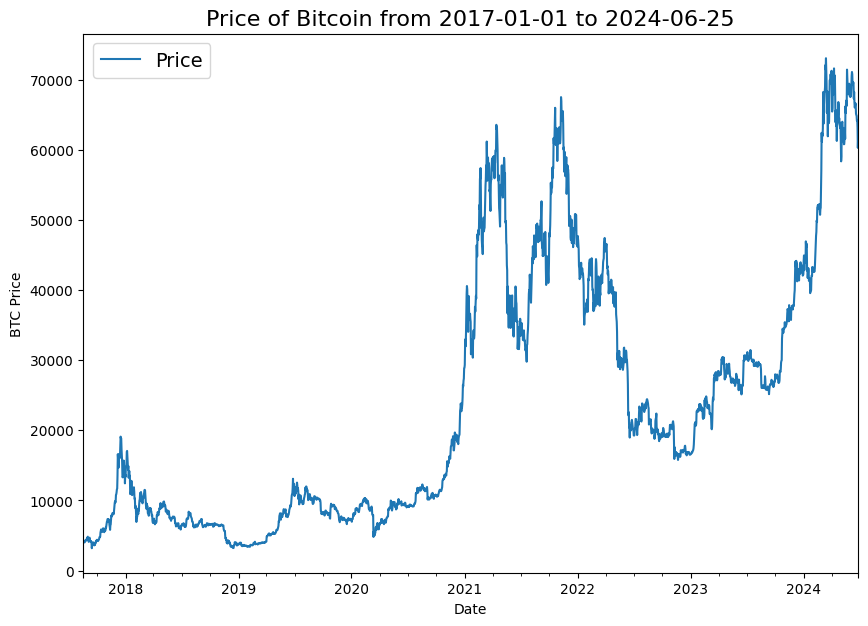

In [8]:
btc_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title(f"Price of Bitcoin from {start_date} to {end_date}", fontsize=16)
plt.legend(fontsize=14);

# Create train & test sets for time series

In [9]:
# Get bitcoin date array
timesteps = btc_prices.index.to_numpy()
prices = btc_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2017-08-17T00:00:00.000000000', '2017-08-18T00:00:00.000000000',
        '2017-08-19T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
        '2017-08-21T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
        '2017-08-23T00:00:00.000000000', '2017-08-24T00:00:00.000000000',
        '2017-08-25T00:00:00.000000000', '2017-08-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([4285.08, 4108.37, 4139.98, 4086.29, 4016.  , 4040.  , 4114.01,
        4316.01, 4280.68, 4337.44]))

In [10]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2004, 501, 2004, 501)

Let's visualize

In [11]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

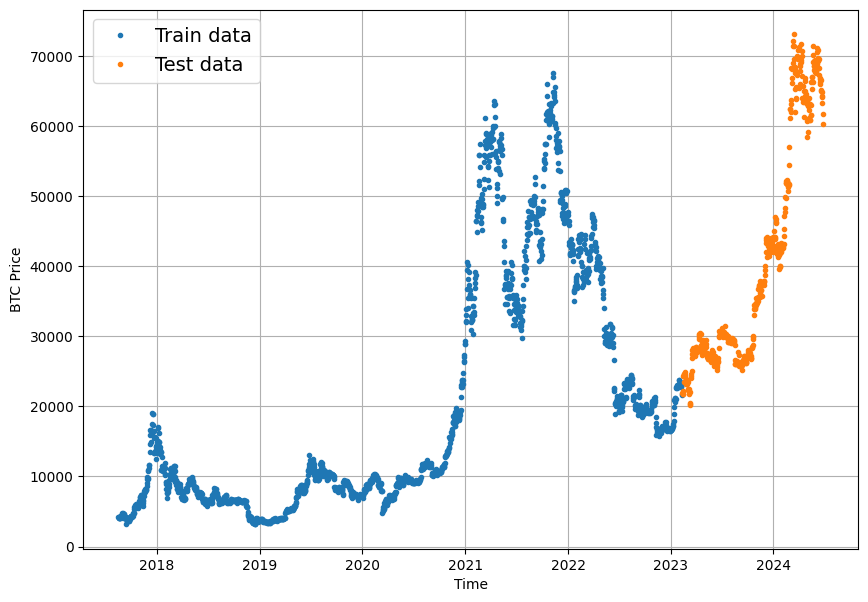

In [12]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Modelling Experiments

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict **horizon**

<table style="width: 100%">
    <tr>
        <th style="text-align: center; vertical-align: middle;">Model Number</th>
        <th style="text-align: center; vertical-align: middle;">Model Type</th>
        <th style="text-align: center; vertical-align: middle;">Horizon size</th>
        <th style="text-align: center; vertical-align: middle;">Window size</th>
        <th style="text-align: center; vertical-align: middle;">Extra data</th>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">0</td>
        <td style="text-align: center; vertical-align: middle;">Forecasting with sktime (baseline)</td>
        <td style="text-align: center; vertical-align: middle;">0.5% data ≈ 13</td>
        <td style="text-align: center; vertical-align: middle;">25</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">Dense model</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">2</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">3</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">4</td>
        <td style="text-align: center; vertical-align: middle;">Conv1D</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">5</td>
        <td style="text-align: center; vertical-align: middle;">LSTM</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">6</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with multivariate data)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">Block reward size</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;"><a href="https://arxiv.org/pdf/1905.10437.pdf">N-BEATs Algorithm</a></td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">8</td>
        <td style="text-align: center; vertical-align: middle;">Ensemble (multiple models optimized on different loss functions)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">9</td>
        <td style="text-align: center; vertical-align: middle;">Future prediction model (model to predict future values)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">10</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with turkey 🦃 data introduced)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
</table>

## Model 0: Naïve forecast (baseline)

In [157]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value

ValueError: x and y must have same first dimension, but have shapes (201,) and (0,)

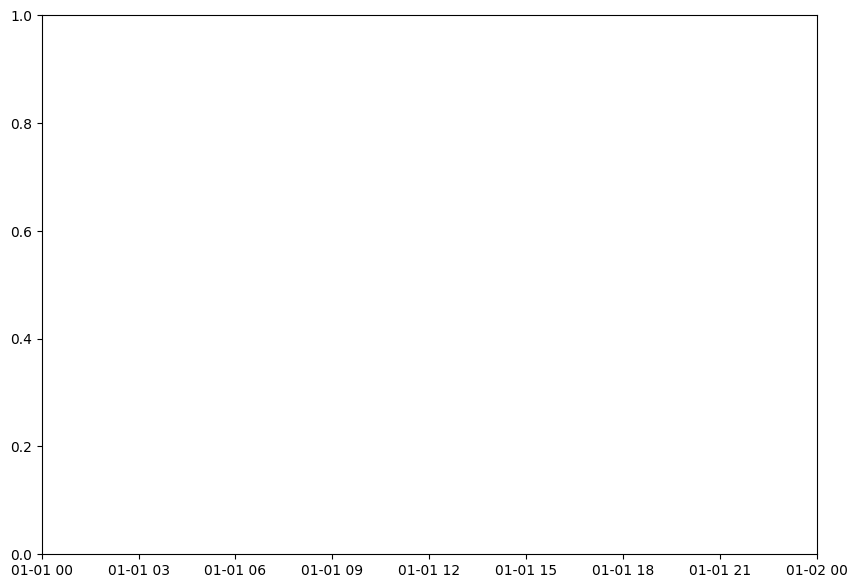

In [158]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [ ]:
def evaluate_preds(y_true, y_pred):
    """
    Evaluate the predictions using common regression metrics.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    dict: A dictionary with the calculated metrics.
    """
    
    # Calculate the metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Print the metrics
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    
    # Return the metrics in a dictionary
    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }
    
    return metrics


In [159]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

Mean Absolute Error (MAE): 781.4950
Mean Squared Error (MSE): 1226436.9439
Root Mean Squared Error (RMSE): 1107.4461
R^2 Score: 0.6528


{'MAE': 781.4949999999984,
 'MSE': 1226436.9439499981,
 'RMSE': 1107.4461359136155,
 'R2': 0.652821123301601}

## Model 0: Forecasting with sktime (baseline)

In [160]:
def custom_plot_series(y_train, y_test, y_pred, start=0, labels=["y_train", "y_test", "y_pred"], marker_size=5):
    plt.figure(figsize=(10, 6))
    plt.plot(y_train[start:].index, y_train[start:], marker='o', markersize=marker_size, label=labels[0])
    plt.plot(y_test[start:].index, y_test[start:], marker='o', markersize=marker_size, label=labels[1])
    plt.plot(y_pred[start:].index, y_pred[start:], marker='o', markersize=marker_size, label=labels[2])
    plt.legend()
    plt.title("Series temporales")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.show()

In [161]:
# Concatenate the train and test sets
dates = np.concatenate((X_train, X_test))
prices = np.concatenate((y_train, y_test))

# Create a DataFrame
data = pd.DataFrame({"Date": dates, "Price": prices})

# Ensure the Date column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [162]:
# Split the data into training and test sets
y_train, y_test = temporal_train_test_split(data['Price'], test_size=0.005)

In [163]:
# Create the regressor
regressor = KNeighborsRegressor(n_neighbors=3)

# Create the forecasting model using make_reduction
forecaster = make_reduction(regressor, window_length=25, strategy="direct")

In [164]:
fh = [i for i in range(1, len(y_test) + 1)]

# Fit the model
forecaster.fit(y_train, fh=fh)

# Make predictions
y_pred = forecaster.predict(fh)

In [165]:
evaluate_preds(y_true=y_test, y_pred=y_pred)

Mean Absolute Error (MAE): 2135.2105
Mean Squared Error (MSE): 6168322.2277
Root Mean Squared Error (RMSE): 2483.6107
R^2 Score: -0.7012


{'MAE': 2135.2105128205117,
 'MSE': 6168322.227703417,
 'RMSE': 2483.6107238662457,
 'R2': -0.7012325750206316}

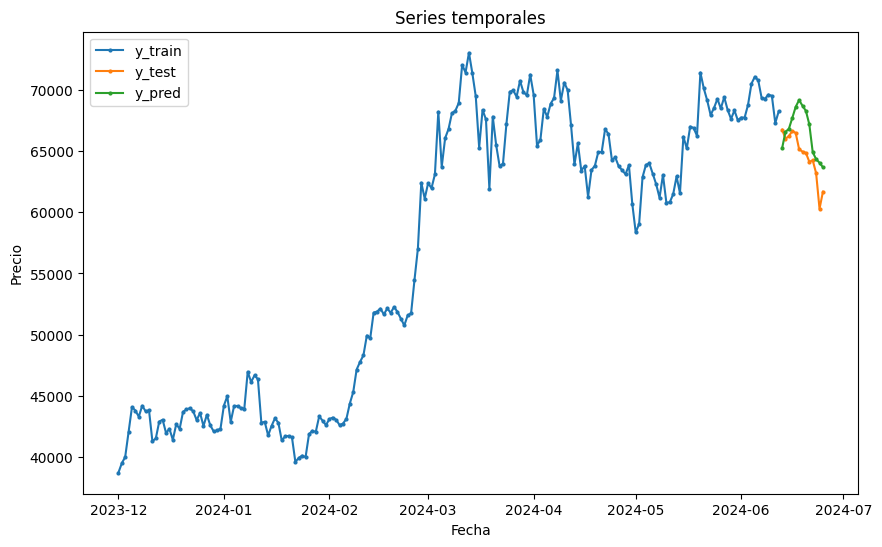

In [166]:
# Plot the predictions
start = pd.to_datetime("2023-12-01")
custom_plot_series(y_train, y_test, y_pred, start=start, marker_size=2)